# Welcome to 24-789 Homework 3

In this homework you will implement a [Denoising Diffusion Probabilistic Model](https://arxiv.org/pdf/2006.11239.pdf). Please start early as diffusion models are notoriously slow to train. Please remember to restart and run all before submission.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


! cp '/content/drive/MyDrive/24788-24789/24789-Homework-3/unet.py' .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from unet import Unet
import os
import math
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [3]:
def create_mnist_dataloaders(batch_size,image_size=28,num_workers=2):
    '''
        Data loading code. Do not modify.
    '''
    
    preprocess=transforms.Compose([transforms.Resize(image_size),\
                                    transforms.ToTensor(),\
                                    transforms.Normalize([0.5],[0.5])]) #[0,1] to [-1,1]

    train_dataset=MNIST(root="./mnist_data",\
                        train=True,\
                        download=True,\
                        transform=preprocess
                        )
    
    # Pick out only the first 5000 1s
    valid_idxs = []
    for idx, d in enumerate(train_dataset):
        if(d[1] in [1]):
            valid_idxs.append(idx)
        if(len(valid_idxs) >= 5000):
            break

    # Create subset
    train_dataset = torch.utils.data.Subset(train_dataset, valid_idxs)

    return DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

## a,b,c,d) Model Implementation

In this section you will implement each part of the diffusion model. That is the model parameters, forward diffusion, reverse diffusion, and the denoising sampling procedure.

In [4]:
import torch.nn as nn
import torch
import math
from unet import Unet
from tqdm import tqdm

class MNISTDiffusion(nn.Module):
    def __init__(self,image_size,in_channels,time_embedding_dim=256,timesteps=1000,base_dim=32,dim_mults= [1, 2, 4, 8]):
        super().__init__()
        
        ###
        #  Part a: Your code here
        ###
        self.timesteps = timesteps
        self.in_channels = in_channels
        self.image_size = image_size

        betas = self._cosine_variance_schedule(timesteps)

        alphas = 1.-betas
        alphas_cumprod = torch.cumprod(alphas,dim=-1)

        self.register_buffer("betas",betas)
        self.register_buffer("alphas",alphas)
        self.register_buffer("alphas_cumprod",alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod",torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod",torch.sqrt(1.-alphas_cumprod))

        self.model = Unet(timesteps,time_embedding_dim,in_channels,in_channels,base_dim,dim_mults)

        
    def _cosine_variance_schedule(self,timesteps,epsilon= 0.008):
        steps = torch.linspace(0,timesteps,steps=timesteps+1,dtype=torch.float32)
        f_t = torch.cos(((steps/timesteps+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
        betas = torch.clip(1.0-f_t[1:]/f_t[:timesteps],0.0,0.999)

        return betas
        

    def forward(self,x,noise):
        # x:NCHW
        # Generate a target time, run forward diffusion, and predict
        t = torch.randint(0,self.timesteps,(x.shape[0],)).to(x.device)
        ###
        #  Part b: Your code here
        ###
        x_t = self._forward_diffusion(x,t,noise)
        pred_noise = self.model(x_t,t)

        return pred_noise
    
    
    def _forward_diffusion(self,x_0,t,noise):
        
        ###
        #  Part b: Your code here
        ###
        assert x_0.shape==noise.shape
        #q(x_{t}|x_{t-1})
        noisy_sample = self.sqrt_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*x_0+ \
                self.sqrt_one_minus_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*noise


        return noisy_sample


    @torch.no_grad()
    def _reverse_diffusion(self,x_t,t,noise):
        '''
        p(x_{t-1}|x_{t})-> mean,std

        pred_noise-> pred_mean and pred_std
        '''
        
        ###
        #  Part c: Your code here
        ###
        pred = self.model(x_t,t)

        alpha_t = self.alphas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        alpha_t_cumprod = self.alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        beta_t = self.betas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        mean = (1./torch.sqrt(alpha_t))*(x_t-((1.0-alpha_t)/sqrt_one_minus_alpha_cumprod_t)*pred)

        if t.min()>0:
            alpha_t_cumprod_prev = self.alphas_cumprod.gather(-1,t-1).reshape(x_t.shape[0],1,1,1)
            std = torch.sqrt(beta_t*(1.-alpha_t_cumprod_prev)/(1.-alpha_t_cumprod))
        else:
            std = 0.0

        return mean+std*noise   

        
    @torch.no_grad()
    def sampling(self,n_samples,device="cuda"):
        
        ###
        #  Part d: Your code here
        ###

        sample = torch.randn((n_samples,self.in_channels,self.image_size,self.image_size)).to(device)
        all_samples = torch.empty([self.timesteps, n_samples, self.in_channels, self.image_size, self.image_size])
        for i in tqdm(range(self.timesteps-1,-1,-1),desc="Sampling"):
            noise = torch.randn_like(sample).to(device)
            t = torch.tensor([i for _ in range(n_samples)]).to(device)

            sample = self._reverse_diffusion(sample,t,noise)
            all_samples[i] = (sample+1.)/2.

        sample = (sample+1.)/2. #[-1,1] to [0,1]

        return sample.clone(), all_samples.clone()

## e) Model Training

Now it is time to implement your training loop. You will need to choose a learning rate, batch size, number of epochs, model dimension, and number of timesteps. You will also need to select an optimizer, scheduler, and loss function.

In [5]:
def main():
    device = "cuda" if torch.cuda.is_available() else 'cpu'

    # Model and training hyperparameters
    lr = 0.0015
    batch_size = 128
    epochs = 200
    model_base_dim = 64

    # Number of noising/denoising steps to take
    timesteps = 15000

    # Controls how often loss is printed and plots are generated
    log_freq = 10
    plot_freq = 40

    # For plotting. Do not modify.
    n_samples = 36

    # Get data
    train_dataloader=create_mnist_dataloaders(batch_size=batch_size,image_size=28)
    
    # Get model
    model=MNISTDiffusion(timesteps=timesteps,
                image_size=28,
                in_channels=1,
                base_dim=model_base_dim,
                dim_mults=[2,4]).to(device)


    optimizer = AdamW(model.parameters(),lr=lr)
    scheduler = OneCycleLR(optimizer, lr, total_steps=epochs*len(train_dataloader), pct_start=0.5, anneal_strategy='cos')
    loss_fn = nn.MSELoss()

    global_steps=0
    for i in range(epochs):
        model.train()
        for j,(image,target) in enumerate(train_dataloader):
            
            # Implement your forward pass and backpropagation
            optimizer.zero_grad()
            noise = torch.randn_like(image).to(device)
            image = image.to(device)
            pred = model(image,noise)
            loss = loss_fn(pred,noise)
            loss.backward()
            optimizer.step()
            scheduler.step()
                
            # Print training progress
            global_steps+=1
            if j%log_freq==0:
                print("Epoch[{}/{}],Step[{}/{}],loss:{:.5f},lr:{:.5f}".format(i+1,epochs,j,len(train_dataloader),
                                                                    loss.detach().cpu().item(),scheduler.get_last_lr()[0]))
        if(i%plot_freq == 0):
            ckpt={"model":model.state_dict()}
            os.makedirs("results",exist_ok=True)
            torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))
            model.eval()
            s, samples = model.sampling(n_samples,device=device)
            save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    # Final round of plots
    os.makedirs("results",exist_ok=True)
    torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))

    model.eval()
    s, samples=model.sampling(n_samples,device=device)
    save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    return samples.cpu()

In [6]:
samples = main()

Epoch[1/200],Step[0/40],loss:1.26921,lr:0.00006
Epoch[1/200],Step[10/40],loss:1.19026,lr:0.00006
Epoch[1/200],Step[20/40],loss:1.12251,lr:0.00006
Epoch[1/200],Step[30/40],loss:1.09118,lr:0.00006


Sampling: 100%|██████████| 15000/15000 [05:53<00:00, 42.48it/s]


Epoch[2/200],Step[0/40],loss:1.04606,lr:0.00006
Epoch[2/200],Step[10/40],loss:1.01507,lr:0.00006
Epoch[2/200],Step[20/40],loss:0.99336,lr:0.00006
Epoch[2/200],Step[30/40],loss:0.96693,lr:0.00006
Epoch[3/200],Step[0/40],loss:0.94021,lr:0.00006
Epoch[3/200],Step[10/40],loss:0.91340,lr:0.00006
Epoch[3/200],Step[20/40],loss:0.88867,lr:0.00006
Epoch[3/200],Step[30/40],loss:0.86333,lr:0.00006
Epoch[4/200],Step[0/40],loss:0.84363,lr:0.00006
Epoch[4/200],Step[10/40],loss:0.81133,lr:0.00006
Epoch[4/200],Step[20/40],loss:0.78477,lr:0.00006
Epoch[4/200],Step[30/40],loss:0.77932,lr:0.00007
Epoch[5/200],Step[0/40],loss:0.74283,lr:0.00007
Epoch[5/200],Step[10/40],loss:0.71255,lr:0.00007
Epoch[5/200],Step[20/40],loss:0.70135,lr:0.00007
Epoch[5/200],Step[30/40],loss:0.68327,lr:0.00007
Epoch[6/200],Step[0/40],loss:0.68270,lr:0.00007
Epoch[6/200],Step[10/40],loss:0.64840,lr:0.00007
Epoch[6/200],Step[20/40],loss:0.60806,lr:0.00007
Epoch[6/200],Step[30/40],loss:0.63037,lr:0.00007
Epoch[7/200],Step[0/40],l

Sampling: 100%|██████████| 15000/15000 [05:50<00:00, 42.76it/s]


Epoch[42/200],Step[0/40],loss:0.06811,lr:0.00058
Epoch[42/200],Step[10/40],loss:0.07066,lr:0.00059
Epoch[42/200],Step[20/40],loss:0.06369,lr:0.00059
Epoch[42/200],Step[30/40],loss:0.06088,lr:0.00060
Epoch[43/200],Step[0/40],loss:0.06025,lr:0.00060
Epoch[43/200],Step[10/40],loss:0.06603,lr:0.00061
Epoch[43/200],Step[20/40],loss:0.05991,lr:0.00061
Epoch[43/200],Step[30/40],loss:0.06915,lr:0.00062
Epoch[44/200],Step[0/40],loss:0.07146,lr:0.00062
Epoch[44/200],Step[10/40],loss:0.05943,lr:0.00063
Epoch[44/200],Step[20/40],loss:0.05994,lr:0.00063
Epoch[44/200],Step[30/40],loss:0.07274,lr:0.00064
Epoch[45/200],Step[0/40],loss:0.06149,lr:0.00065
Epoch[45/200],Step[10/40],loss:0.05896,lr:0.00065
Epoch[45/200],Step[20/40],loss:0.07324,lr:0.00066
Epoch[45/200],Step[30/40],loss:0.06028,lr:0.00066
Epoch[46/200],Step[0/40],loss:0.05977,lr:0.00067
Epoch[46/200],Step[10/40],loss:0.05618,lr:0.00067
Epoch[46/200],Step[20/40],loss:0.05797,lr:0.00068
Epoch[46/200],Step[30/40],loss:0.05792,lr:0.00068
Epoch

Sampling: 100%|██████████| 15000/15000 [05:48<00:00, 43.07it/s]


Epoch[82/200],Step[0/40],loss:0.03441,lr:0.00138
Epoch[82/200],Step[10/40],loss:0.03894,lr:0.00138
Epoch[82/200],Step[20/40],loss:0.03710,lr:0.00138
Epoch[82/200],Step[30/40],loss:0.04455,lr:0.00139
Epoch[83/200],Step[0/40],loss:0.04627,lr:0.00139
Epoch[83/200],Step[10/40],loss:0.02861,lr:0.00139
Epoch[83/200],Step[20/40],loss:0.03112,lr:0.00139
Epoch[83/200],Step[30/40],loss:0.03105,lr:0.00140
Epoch[84/200],Step[0/40],loss:0.05220,lr:0.00140
Epoch[84/200],Step[10/40],loss:0.04016,lr:0.00140
Epoch[84/200],Step[20/40],loss:0.03045,lr:0.00141
Epoch[84/200],Step[30/40],loss:0.03139,lr:0.00141
Epoch[85/200],Step[0/40],loss:0.03534,lr:0.00141
Epoch[85/200],Step[10/40],loss:0.03236,lr:0.00141
Epoch[85/200],Step[20/40],loss:0.03284,lr:0.00142
Epoch[85/200],Step[30/40],loss:0.03173,lr:0.00142
Epoch[86/200],Step[0/40],loss:0.03428,lr:0.00142
Epoch[86/200],Step[10/40],loss:0.03860,lr:0.00142
Epoch[86/200],Step[20/40],loss:0.03278,lr:0.00143
Epoch[86/200],Step[30/40],loss:0.03104,lr:0.00143
Epoch

Sampling: 100%|██████████| 15000/15000 [05:51<00:00, 42.63it/s]


Epoch[122/200],Step[0/40],loss:0.02766,lr:0.00134
Epoch[122/200],Step[10/40],loss:0.02830,lr:0.00134
Epoch[122/200],Step[20/40],loss:0.02630,lr:0.00133
Epoch[122/200],Step[30/40],loss:0.02533,lr:0.00133
Epoch[123/200],Step[0/40],loss:0.02842,lr:0.00133
Epoch[123/200],Step[10/40],loss:0.02348,lr:0.00132
Epoch[123/200],Step[20/40],loss:0.02725,lr:0.00132
Epoch[123/200],Step[30/40],loss:0.02467,lr:0.00132
Epoch[124/200],Step[0/40],loss:0.04131,lr:0.00131
Epoch[124/200],Step[10/40],loss:0.02837,lr:0.00131
Epoch[124/200],Step[20/40],loss:0.02912,lr:0.00130
Epoch[124/200],Step[30/40],loss:0.02736,lr:0.00130
Epoch[125/200],Step[0/40],loss:0.02446,lr:0.00130
Epoch[125/200],Step[10/40],loss:0.03101,lr:0.00129
Epoch[125/200],Step[20/40],loss:0.02746,lr:0.00129
Epoch[125/200],Step[30/40],loss:0.02730,lr:0.00128
Epoch[126/200],Step[0/40],loss:0.02779,lr:0.00128
Epoch[126/200],Step[10/40],loss:0.02938,lr:0.00128
Epoch[126/200],Step[20/40],loss:0.02610,lr:0.00127
Epoch[126/200],Step[30/40],loss:0.02

Sampling: 100%|██████████| 15000/15000 [05:50<00:00, 42.83it/s]


Epoch[162/200],Step[0/40],loss:0.02390,lr:0.00049
Epoch[162/200],Step[10/40],loss:0.02470,lr:0.00049
Epoch[162/200],Step[20/40],loss:0.02417,lr:0.00048
Epoch[162/200],Step[30/40],loss:0.02585,lr:0.00048
Epoch[163/200],Step[0/40],loss:0.02709,lr:0.00047
Epoch[163/200],Step[10/40],loss:0.02777,lr:0.00047
Epoch[163/200],Step[20/40],loss:0.02332,lr:0.00046
Epoch[163/200],Step[30/40],loss:0.03039,lr:0.00046
Epoch[164/200],Step[0/40],loss:0.02340,lr:0.00045
Epoch[164/200],Step[10/40],loss:0.02690,lr:0.00045
Epoch[164/200],Step[20/40],loss:0.02412,lr:0.00044
Epoch[164/200],Step[30/40],loss:0.02362,lr:0.00043
Epoch[165/200],Step[0/40],loss:0.02519,lr:0.00043
Epoch[165/200],Step[10/40],loss:0.02522,lr:0.00042
Epoch[165/200],Step[20/40],loss:0.02294,lr:0.00042
Epoch[165/200],Step[30/40],loss:0.02249,lr:0.00041
Epoch[166/200],Step[0/40],loss:0.02263,lr:0.00041
Epoch[166/200],Step[10/40],loss:0.02466,lr:0.00040
Epoch[166/200],Step[20/40],loss:0.02323,lr:0.00040
Epoch[166/200],Step[30/40],loss:0.02

Sampling: 100%|██████████| 15000/15000 [05:49<00:00, 42.93it/s]


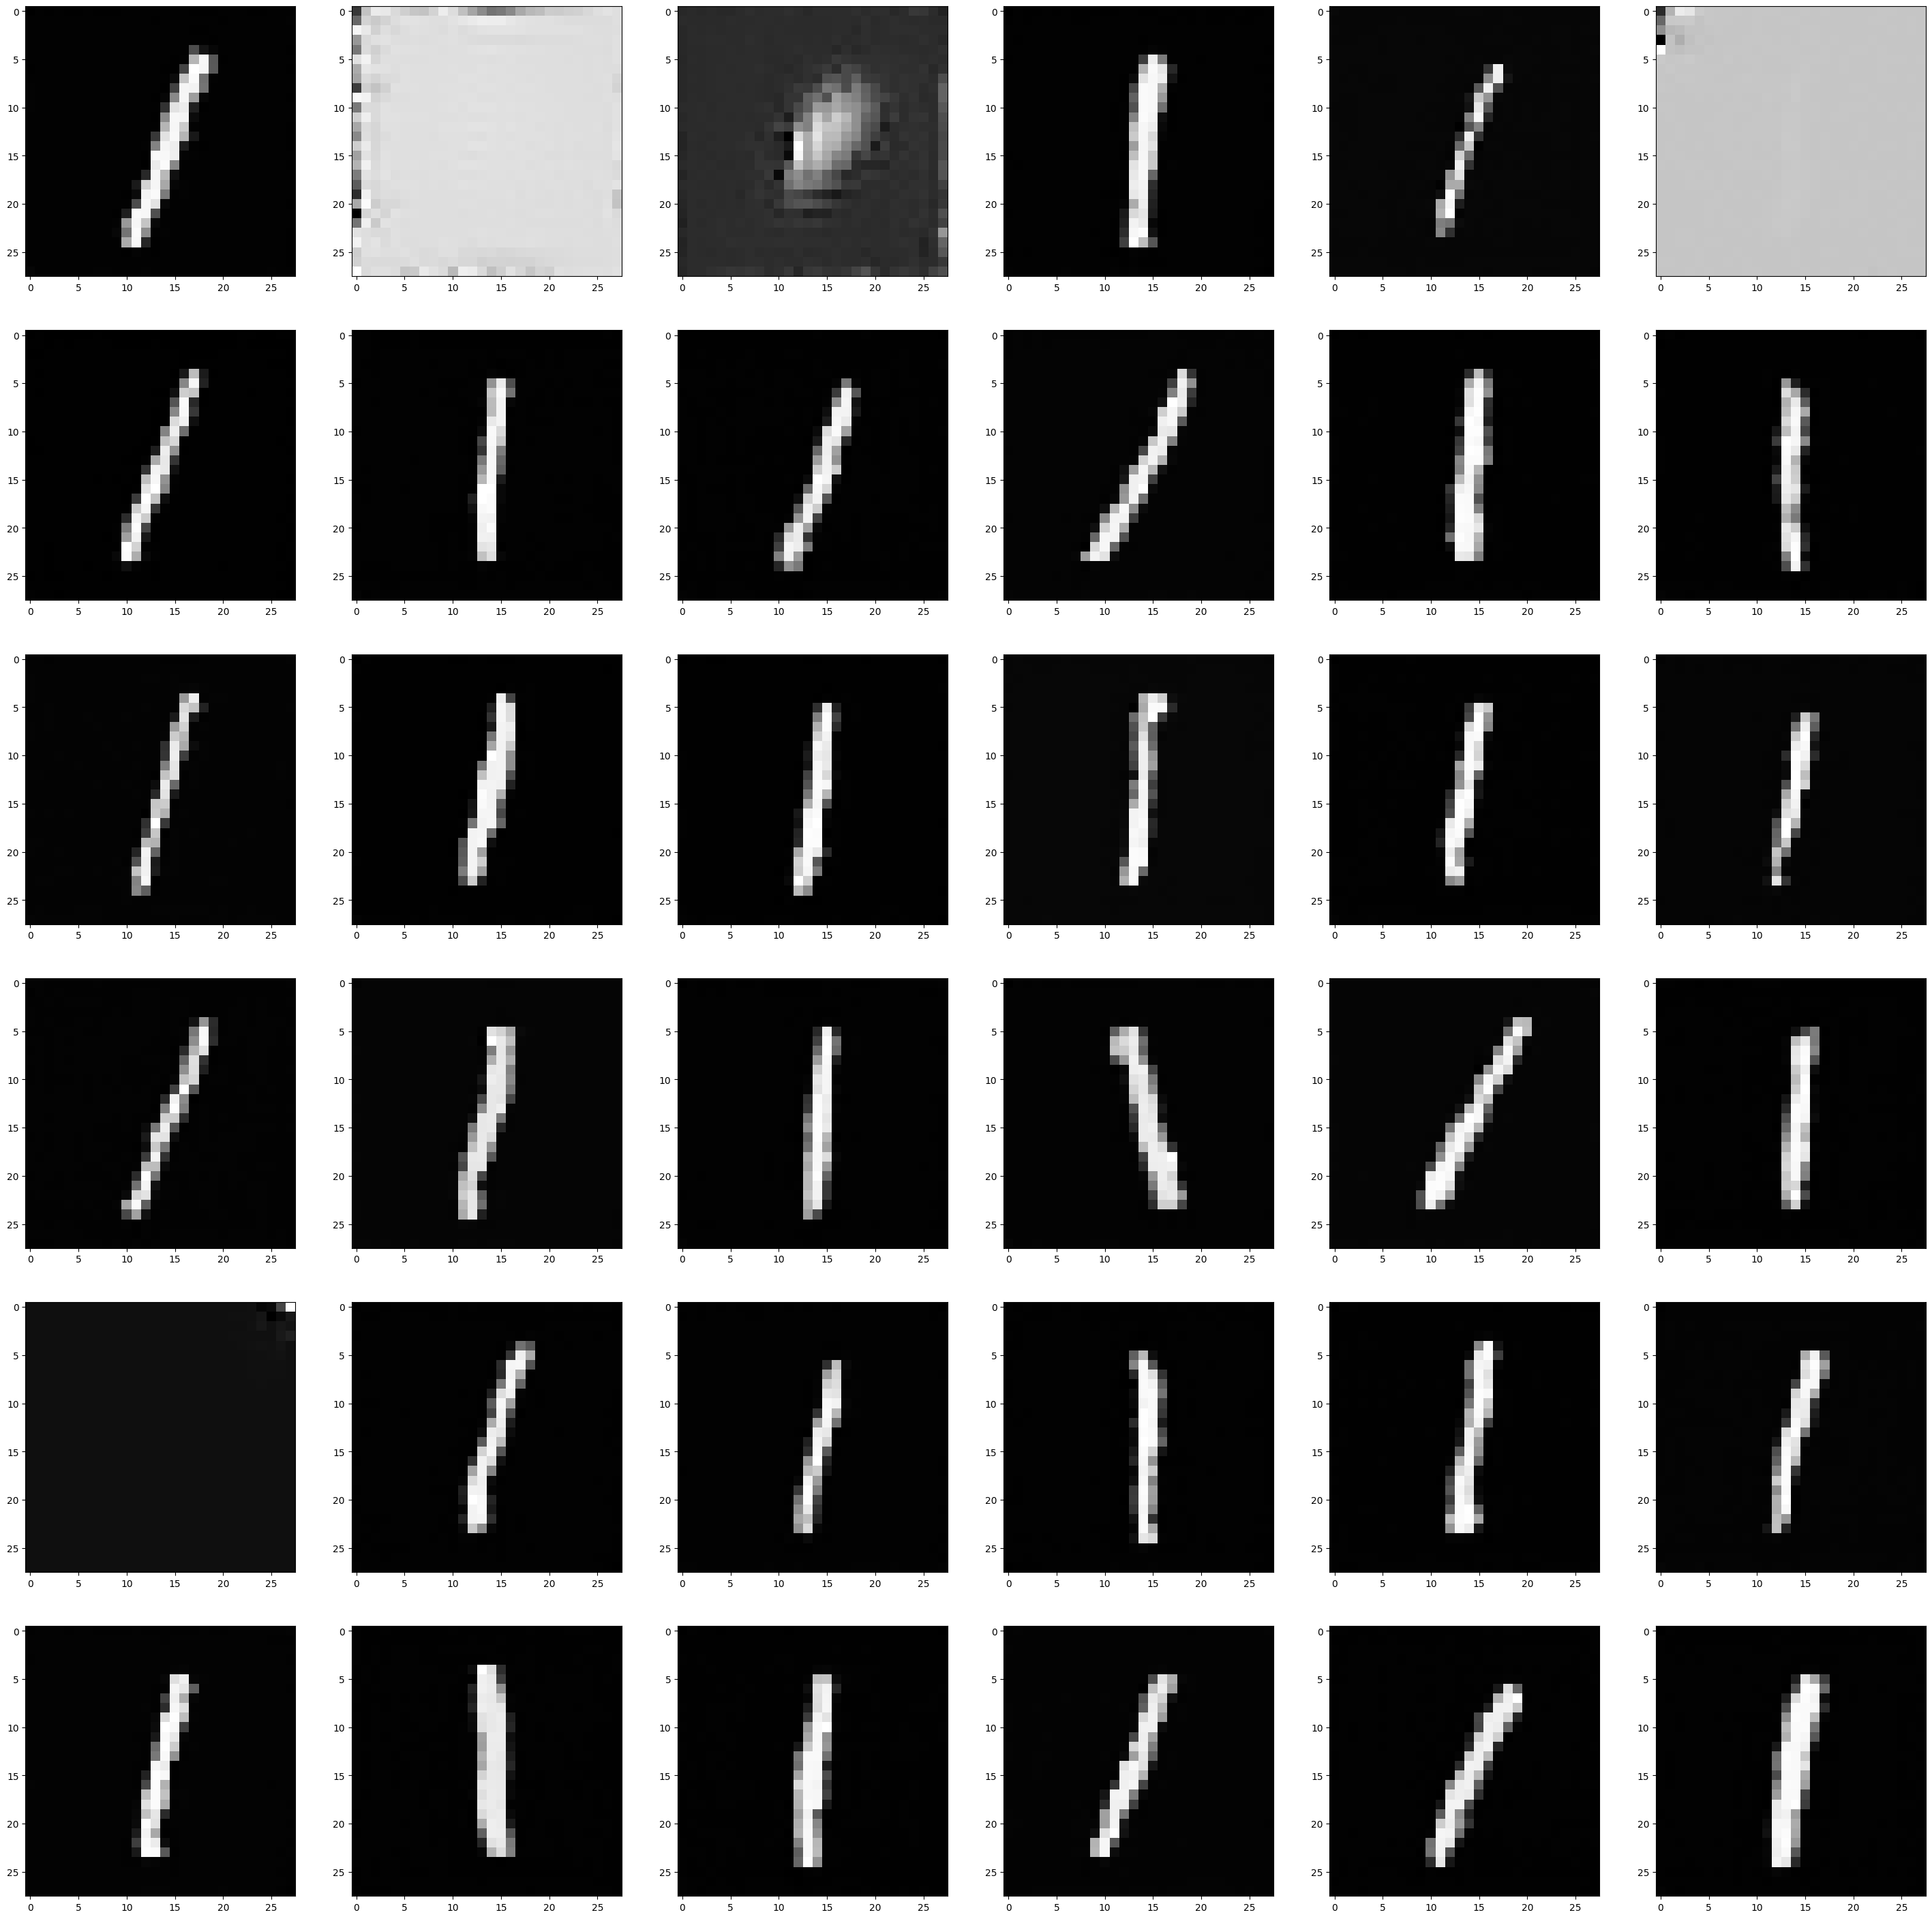

In [7]:
# Plotting code for your final samples
fig, ax = plt.subplots(ncols=6, nrows=6, figsize=(36,36))
for i in range(36):
    ax[i//6][i%6].imshow(samples[0][i][0], cmap='gray',  interpolation='nearest')
plt.savefig("./learned_diffusion_ones.pdf")
plt.show()

## f) Diffusion Visualization
Here you will need to implement a plotting function that visualizes noise turning into a clean sample. Do not forget to label each image with its corresponding denoising step.

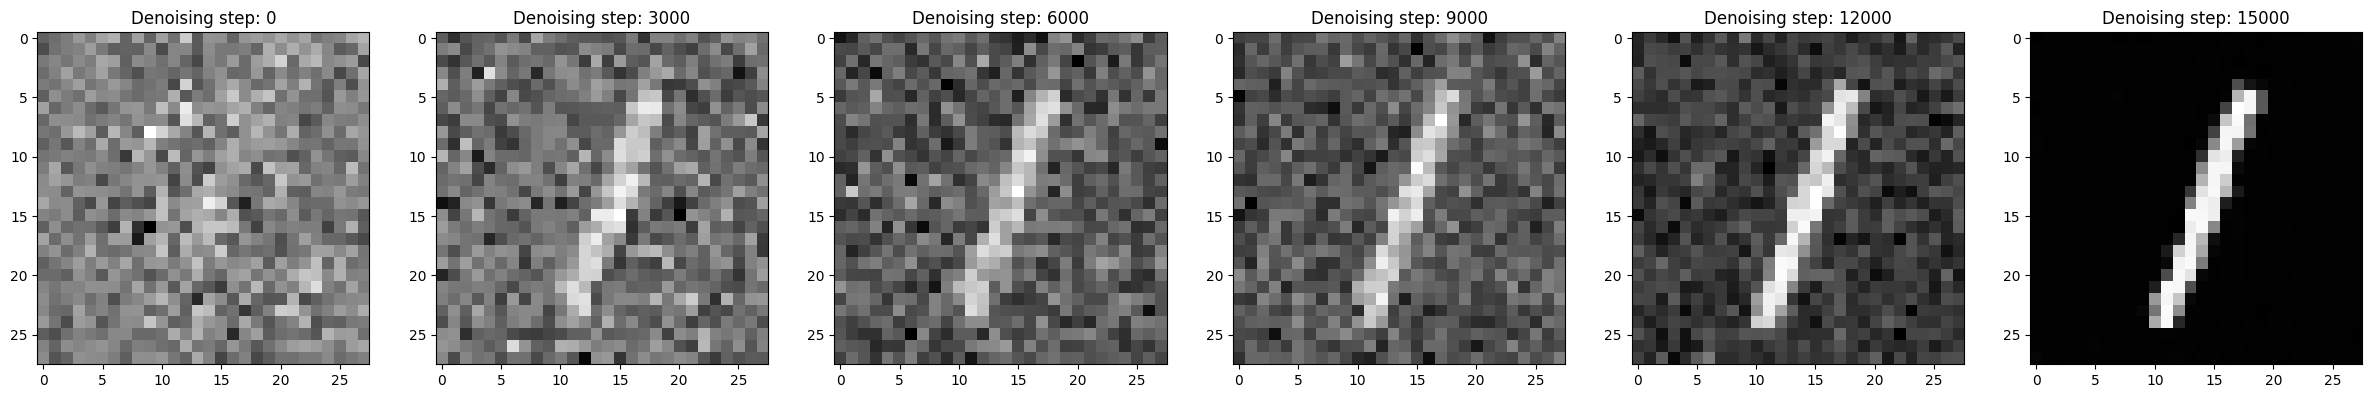

In [8]:
fig, ax = plt.subplots(ncols=6, figsize=(30,7))

###
#  Your code here
###
for i in range(6):
  ax[i].imshow(samples[14999-(i*2999)][0][0], cmap='gray',  interpolation='nearest')
  ax[i].set_title(f'Denoising step: {i*3000}')

plt.show()